In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import numpy_financial as npf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
DIR = '../data/values/'
city_bottom_file = 'City_zhvi_uc_sfrcondo_tier_0.0_0.33_sm_sa_mon.csv'
city_middle_file = 'City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv'
city_top_file = 'City_zhvi_uc_sfrcondo_tier_0.67_1.0_sm_sa_mon.csv'

city_files = {'Bottom tier':city_bottom_file, 'Middle tier':city_middle_file, 'Top tier':city_top_file}

neigh_file = 'Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv'

In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [9]:
import matplotlib
np.__version__

'1.19.4'

In [47]:
cities = {
    'Los Angeles':['Palms','Mar Vista','Westchester','Del Rey','Venice','Playa Del Rey','West Los Angeles','Playa Vista'],
    'Culver City':['Fox Hills', 'Park East', 'Clarkdale', 'Jefferson', 'Culver West', 'Park West', 'Blanco-Culver Crest', 'Lucerne-Higuera','McLaughlin', 'Sunkist Park', 'Studio Village','Washington Culver', 'McManus', 'Blair Hills'],
    'Huntington Beach':['Sunset Beach', 'Huntington Harbour'],
    'Santa Monica':['Wilshire-Montana', 'Sunset Park', 'Mid-City', 'Ocean Park', 'Pico District', 'Downtown-Third Street Promenade','North of Montana', 'Northeast','Santa Monica Pier Area-Ocean Avenue']
         }

In [109]:
#All inputs

region_type = 'neighbourhood' #city or neighbourhood. If region_type==neighbourhood, then the name of the neighbourhood has to be specified
city = 'Huntington Beach'
neighbourhood = 'Sunset Beach'

home_value = 800000
down_payment_percent = 20
interest_rate = 2.8
payment_years = 15
typical_tax_rate = 1.25 # a typical tax rate for the area. CA is usually 1.25 in total
typical_rent_rate = 4 # the increase in rent price (per year)

homeowners_insurance_y = 1200 # Insurance per year
hoa = 395 #HOA monthly fees 

current_rent = 2900

train_years = 20 # years used to calculate the price trends for the selected area
test_years = 5 # this is used only to plot the linear trends at the end

In [110]:
#Get the proper file, depending on the property price
print('Chosing the proper data o load based on the price tier of the property...')
if region_type == 'city':
    diff = {}
    for k,v in city_files.items():
        d = pd.read_csv(DIR+v)
        d = d[(d['RegionName']==city)]
        val = d.iloc[0].iloc[-1]
        diff[v] = abs(home_value - val)
        print(k + '...')
    f = min(diff, key=diff.get)
    print('Chosen: ' + str(list(city_files.keys())[list(city_files.values()).index(f)]))
    print('Load data...')
    a = pd.read_csv(DIR+f)
    d = a[(a['RegionName']==city)]
if region_type == 'neighbourhood':
    a = pd.read_csv(DIR+neigh_file)
    d = a[(a['City']==city) & (a['RegionName']==neighbourhood)]

Chosing the proper data o load based on the price tier of the property...


In [111]:
d = d.T.iloc[-1*train_years*12:].reset_index()
d.columns = ['date','value']
d['value'] = d['value'].astype('float')
d['date'] = pd.to_datetime(d['date'])
d = d.set_index('date')


y_pre = d['value'].values
x_pre = range(0,len(y_pre))
x_pre = sm.add_constant(x_pre)
results_pre = sm.OLS(y_pre,x_pre).fit()

periods = test_years*12
x1n = np.linspace(x_pre.max()+1,x_pre.max()+periods, periods)
Xnew = sm.add_constant(x1n)

predictions = results_pre.get_prediction(Xnew).summary_frame(alpha=0.05)
move = predictions['mean'].iloc[0] - y_pre[-1]
moved_predictions = predictions - move

In [112]:
#average percent price increase
per = d.pct_change(periods=1).dropna()
price_growth = per['value'].mean()

In [113]:
down_payment = home_value* (down_payment_percent / 100)
loan_amount = home_value - down_payment
payment_months = payment_years*12
interest_rate = interest_rate / 100
periodic_interest_rate = (1+interest_rate)**(1/12) - 1
monthly_installment = -1*npf.pmt(periodic_interest_rate , payment_months, loan_amount)

In [114]:
principal_remaining = np.zeros(payment_months)
interest_pay_arr = np.zeros(payment_months)
principal_pay_arr = np.zeros(payment_months)

for i in range(0, payment_months):
    
    if i == 0:
        previous_principal_remaining = loan_amount
    else:
        previous_principal_remaining = principal_remaining[i-1]
        
    interest_payment = round(previous_principal_remaining*periodic_interest_rate, 2)
    principal_payment = round(monthly_installment - interest_payment, 2)
    
    if previous_principal_remaining - principal_payment < 0:
        principal_payment = previous_principal_remaining
    
    interest_pay_arr[i] = interest_payment 
    principal_pay_arr[i] = principal_payment
    principal_remaining[i] = previous_principal_remaining - principal_payment
    

month_num = np.arange(payment_months)
month_num = month_num + 1
principal_remaining = np.around(principal_remaining, decimals=2)

cumulative_home_equity = np.cumsum(principal_pay_arr)
cumulative_interest_paid = np.cumsum(interest_pay_arr)

In [115]:
amortization_schedule = pd.DataFrame(list(zip(principal_pay_arr,interest_pay_arr,principal_remaining)), columns=['Principal Payment','Interest Payment','Remaining Principal'])
amortization_schedule['Monthly Payment'] = amortization_schedule['Principal Payment'] + amortization_schedule['Interest Payment']
amortization_schedule['Cumulative Home Equity'] = cumulative_home_equity
amortization_schedule['Cumulative Interest Paid'] = cumulative_interest_paid

In [116]:
forecast_growth = price_growth*100
#forecast_growth = -5

#growth_per_month = (forecast_growth / 12.0) / 100 
growth_per_month = (forecast_growth) / 100 
growth_array = np.full(payment_months, growth_per_month)
forecast_cumulative_growth = np.cumprod(1+growth_array)
forecast_home_value = home_value*forecast_cumulative_growth
cumulative_percent_owned = (down_payment_percent/100) + (cumulative_home_equity/home_value)
forecast_home_equity = cumulative_percent_owned*forecast_home_value

In [117]:
amortization_schedule['forecast_cumulative_growth'] = forecast_cumulative_growth
amortization_schedule['forecast_home_value'] = forecast_home_value
amortization_schedule['forecast_home_equity'] = forecast_home_equity
amortization_schedule['homeowners_insurance'] = homeowners_insurance_y/12

In [118]:
# calculate taxes
assessed_values = [home_value]
for i in range(0,payment_years-1):
    assessed_value = assessed_values[i] + assessed_values[i] * 2/100
    assessed_values.append(assessed_value)

taxes_y = [x*typical_tax_rate/100 for x in assessed_values]
taxes_m = []
for y in range(0,payment_years):
    taxes_m = taxes_m + [taxes_y[y]/12] * 12

In [119]:
# calculate rent
rents = [current_rent]
for i in range(0,payment_years-1):
    rent = rents[i] + rents[i] * typical_rent_rate/100
    rents.append(rent)
    
rents_m = []
for y in range(0,payment_years):
    rents_m = rents_m + [rents[y]] * 12

In [120]:
amortization_schedule['taxes'] = taxes_m
amortization_schedule['hoa'] = hoa
amortization_schedule['rent'] = rents_m
amortization_schedule['selling_fees'] = amortization_schedule['forecast_home_value']*0.1

amortization_schedule['Total Monthly Payment'] = \
amortization_schedule['Monthly Payment'] \
+ amortization_schedule['homeowners_insurance']\
+ amortization_schedule['taxes']\
+ amortization_schedule['hoa']

amortization_schedule['Cumulative Monthly Payment'] = amortization_schedule['Total Monthly Payment'].cumsum()
amortization_schedule['cumulative_rent'] = amortization_schedule['rent'].cumsum()

In [121]:
c = amortization_schedule['Cumulative Monthly Payment'] + down_payment + amortization_schedule['selling_fees']- amortization_schedule['cumulative_rent']

In [122]:
# identify the threshold criteria where it becomes smart to sell the house
# the forecasted home equity should be higher than the costs: 
# cumulative total monthly payment + downpayment + selling fees - cumulative rent
crit = amortization_schedule['Cumulative Monthly Payment'] + down_payment + amortization_schedule['selling_fees'] - amortization_schedule['cumulative_rent'] < amortization_schedule['forecast_home_equity']
before_criterion = amortization_schedule.where(~crit).dropna()

In [123]:
amortization_schedule

,Principal Payment,Interest Payment,Remaining Principal,Monthly Payment,Cumulative Home Equity,Cumulative Interest Paid,forecast_cumulative_growth,forecast_home_value,forecast_home_equity,homeowners_insurance,taxes,hoa,rent,selling_fees,Total Monthly Payment,Cumulative Monthly Payment,cumulative_rent
0,2873.16,1474.50,637126.84,4347.66,2873.16,1474.50,1.004155,8.033240e+05,1.635499e+05,100.0,833.333333,395,2900.000000,80332.397153,5675.993333,5.675993e+03,2900.000000
1,2879.77,1467.89,634247.07,4347.66,5752.93,2942.39,1.008327,8.066618e+05,1.671332e+05,100.0,833.333333,395,2900.000000,80666.175404,5675.993333,1.135199e+04,5800.000000
2,2886.41,1461.25,631360.66,4347.66,8639.34,4403.64,1.012517,8.100134e+05,1.707502e+05,100.0,833.333333,395,2900.000000,81001.340493,5675.993333,1.702798e+04,8700.000000
3,2893.06,1454.60,628467.60,4347.66,11532.40,5858.24,1.016724,8.133790e+05,1.744011e+05,100.0,833.333333,395,2900.000000,81337.898180,5675.993333,2.270397e+04,11600.000000
4,2899.72,1447.94,625567.88,4347.66,14432.12,7306.18,1.020948,8.167585e+05,1.780862e+05,100.0,833.333333,395,2900.000000,81675.854252,5675.993333,2.837997e+04,14500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,4297.92,49.74,17290.01,4347.66,622709.99,142478.17,2.074580,1.659664e+06,1.623794e+06,100.0,1099.565636,395,5021.861698,165966.400021,5942.225636,1.020844e+06,676733.402999
176,4307.83,39.83,12982.18,4347.66,627017.82,142518.00,2.083200,1.666560e+06,1.639515e+06,100.0,1099.565636,395,5021.861698,166655.984507,5942.225636,1.026786e+06,681755.264697
177,4317.75,29.91,8664.43,4347.66,631335.57,142547.91,2.091855,1.673484e+06,1.655360e+06,100.0,1099.565636,395,5021.861698,167348.434191,5942.225636,1.032729e+06,686777.126395
178,4327.70,19.96,4336.73,4347.66,635663.27,142567.87,2.100547,1.680438e+06,1.671328e+06,100.0,1099.565636,395,5021.861698,168043.760980,5942.225636,1.038671e+06,691798.988093


City: Huntington Beach
Neighbourhood: Sunset Beach
Home value: 800000
Down payment: 20%
Interest rate: 2.8%
Years: 15
Tax rate: 1.25%
Homeowners insurance (per year): 1200
HOA: 395
Current (starting) rent: 2900
Rent increase (per year): 4%
Average monthly price growth for Sunset Beach(last 20y): 0.415%
Average yearly price growth for Sunset Beach(last 20y): 4.986%
Monthly Mortgage Payment: 4348
Total Monthly Payment in the first year: 5676
Total Monthly Payment in the second year: 5693
Total Monthly Payment in the third year: 5710
Sell after: 51 months; 4.25 years


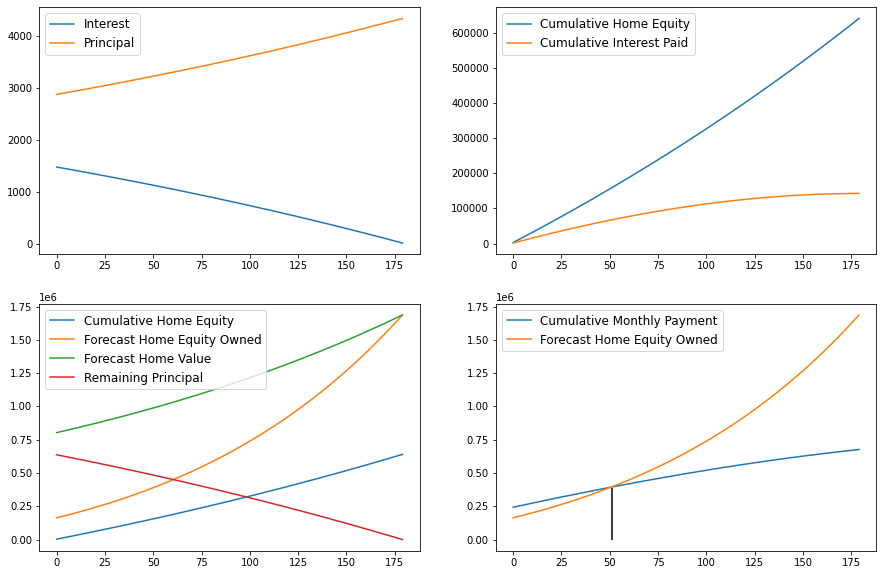

In [124]:
fig, ax = plt.subplots(2,2,figsize=(15,10));
ax[0,0].plot(interest_pay_arr, label = 'Interest')
ax[0,0].plot(principal_pay_arr, label = 'Principal')
ax[0,0].legend(fontsize=12);

ax[0,1].plot(cumulative_home_equity, label = 'Cumulative Home Equity')
ax[0,1].plot(cumulative_interest_paid, label = 'Cumulative Interest Paid')
ax[0,1].legend(fontsize=12);

ax[1,0].plot(cumulative_home_equity, label = 'Cumulative Home Equity')
ax[1,0].plot(forecast_home_equity, label = 'Forecast Home Equity Owned')
ax[1,0].plot(forecast_home_value, label = 'Forecast Home Value')
ax[1,0].plot(principal_remaining, label = 'Remaining Principal')
ax[1,0].legend(fontsize=12);

ax[1,1].plot(c.values, label = 'Cumulative Monthly Payment')
ax[1,1].plot(forecast_home_equity, label = 'Forecast Home Equity Owned')
ax[1,1].vlines(x=len(before_criterion),ymin=0,ymax=before_criterion['forecast_home_equity'].iloc[-1])
ax[1,1].legend(fontsize=12);

print('City: ' + city)
if region_type == 'neighbourhood':
    print('Neighbourhood: ' + neighbourhood)
print('Home value: ' + str(home_value))
print('Down payment: ' + str(down_payment_percent) + '%')
print('Interest rate: ' + str(round(interest_rate*100,2)) + '%')
print('Years: ' + str(payment_years))
print('Tax rate: ' + str(typical_tax_rate) + '%')
print('Homeowners insurance (per year): ' + str(homeowners_insurance_y))
print('HOA: ' + str(hoa))
print('==================================')
print('Current (starting) rent: ' + str(current_rent))
print('Rent increase (per year): ' + str(typical_rent_rate) + '%')
print('==================================')
if region_type == 'neighbourhood':
    print('Average monthly price growth for ' + neighbourhood + '(last ' + str(train_years) + 'y)' + ': ' + str(round(price_growth*100,3)) + '%')
    print('Average yearly price growth for ' + neighbourhood + '(last ' + str(train_years) + 'y)' + ': ' + str(round(price_growth*100*12,3)) + '%')
if region_type == 'city':
    print('Average monthly price growth for ' + city + '(last ' + str(train_years) + 'y)' + ': ' + str(round(price_growth*100,3)) + '%')
    print('Average yearly price growth for ' + city + '(last ' + str(train_years) + 'y)' + ': ' + str(round(price_growth*100*12,3)) + '%')
print('Monthly Mortgage Payment: ' + str(round(amortization_schedule['Monthly Payment'].iloc[0])))
print('Total Monthly Payment in the first year: ' + str(round(amortization_schedule['Total Monthly Payment'].iloc[0])))
print('Total Monthly Payment in the second year: ' + str(round(amortization_schedule['Total Monthly Payment'].iloc[12])))
print('Total Monthly Payment in the third year: ' + str(round(amortization_schedule['Total Monthly Payment'].iloc[24])))
print('==================================')
print('Sell after: ' + str(len(before_criterion)) + ' months; ' + str(round(len(before_criterion)/12,2)) + ' years')

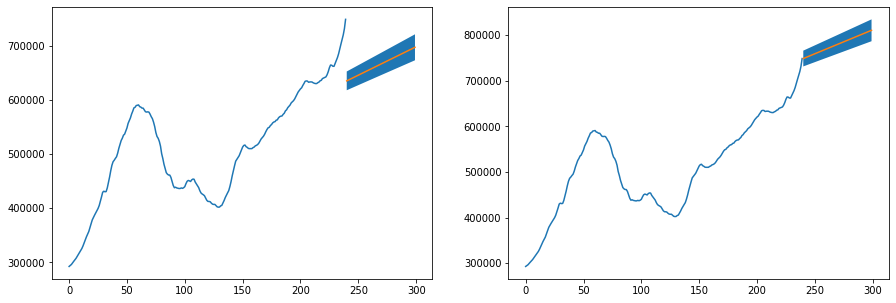

In [45]:
x_plot1 = list(range(0,len(y_pre))) 
x_plot2 = list(range(len(y_pre),len(y_pre)+len(predictions)))

fig, ax = plt.subplots(1,2,figsize=(15,5));
ax[0].plot(x_plot1,y_pre);
ax[0].plot(x_plot2,predictions['mean'].values);
ax[0].fill_between(x_plot2,predictions['mean_ci_lower'],predictions['mean_ci_upper']);

ax[1].plot(x_plot1,y_pre);
ax[1].plot(x_plot2,moved_predictions['mean'].values);
ax[1].fill_between(x_plot2,moved_predictions['mean_ci_lower'],moved_predictions['mean_ci_upper']);